# Tutorial `kpm_tools.bloch`

When computing the Kubo-Bastin conductivity with `kwant.kpm.conductivity`, the boundary effects are important. Actually, for any open boundary system, the (overall) Hall conductivity will be zero within all gaps, topological and trivial ones.

A workaround is to compute the conductivity at the bulk of the sample, to avoid boundary effects. This implies extra care on defining the KPM vectors, and the need for a larger system such that boundaries are far enough from the 'bulk' where the conductivity is computed.

To address these issues, we can define a system with periodic boundary conditions, in which case we also need periodic velocity operators. The exact shape of the periodic operators depends on the details of the system and on the edges that are wrapped around with `kwant.wraparound`.
The module `kpm_tools.bloch` takes care of correctly defining periodic velocity operators for any wrapped around system.

Here we will demonstrate the `bloch` module using a system with periodic boundary conditions to get the periodic velocity operators.
If we would use the non-periodic velocity operators the results would be inconsistent.

This is evident when comparing the Kubo-Bastin longitudinal and Hall conductivity for a small topological system.

### First some basic imports and plotting functions

In [1]:
import numpy as np
import kwant
from kpm_tools import bloch
from kpm_tools.bloch import wrap_velocity
from kpm_tools.hamiltonians import haldane_pbc

# plotting
import matplotlib.pyplot, matplotlib.backends
import matplotlib.pyplot as plt
import holoviews as hv
hv.notebook_extension()


def plot_dos_and_curves(dos, labels_to_data, ylabel="DoS [a.u.]"):
    plt.figure(figsize=(5,4))
    plt.fill_between(dos[0], dos[1], label="DoS [a.u.]",
                     alpha=0.5, color='gray')
    for label, (x, y) in labels_to_data:
        plt.plot(x, y, label=label, linewidth=2)
    plt.legend(framealpha=0.5)
    plt.xlabel("energy [t]")
    plt.ylabel(ylabel)

    plt.ylim(-2, 4)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

## Define a periodic Haldane topological system

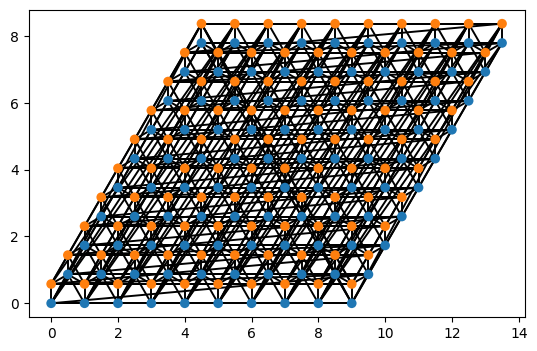

In [2]:
lx = 10
ly = 10
trans_symm = [(lx, 0), (0, ly)]
lat, syst = haldane_pbc(trans_symm, return_builder=True)


fsyst = kwant.wraparound.wraparound(syst).finalized()

norbs = fsyst.sites[0].family.norbs
bounds = (-3.1, 3.1)


params = dict(zip(fsyst._momentum_names, (0, 0)))


kwant.plot(fsyst);


### Define periodic velocity operators on the periodic system

In [3]:
velocity_builder = wrap_velocity(syst)
vx = velocity_builder.hamiltonian_submatrix(params=dict(k_x=0, k_y=0, direction=[1, 0]), sparse=True)
vy = velocity_builder.hamiltonian_submatrix(params=dict(k_x=0, k_y=0, direction=[0, 1]), sparse=True)


## Use periodic velocity operators
(in a periodic system)

In [4]:
s_factory = kwant.kpm.LocalVectors(fsyst, where=None)
vectors = list(s_factory)
num_vectors = len(vectors)

# number of sites per vector
norm_v = np.linalg.norm(vectors[0]) ** 2

cond_xx = kwant.kpm.conductivity(
    fsyst, params=params,
    bounds=bounds,
    alpha=vx,
    beta=vx,
    mean=False,
    num_vectors=num_vectors,
    vector_factory=vectors)

cond_xy = kwant.kpm.conductivity(
    fsyst, params=params,
    alpha=vx,
    beta=vy,
    mean=False,
    num_vectors=num_vectors,
    vector_factory=vectors
)

energies = cond_xx.energies
cond_array_xx = np.array([cond_xx(e, temperature=0.0) for e in energies]).real
cond_array_xy = np.array([cond_xy(e, temperature=0.0) for e in energies]).real

# area of the unit cell per site
area_per_site = np.abs(np.cross(*lat.prim_vecs)) / len(lat.sublattices)
cond_array_xx /= area_per_site
cond_array_xy /= area_per_site

cond_array_xx = cond_array_xx / norm_v
cond_array_xy = cond_array_xy / norm_v


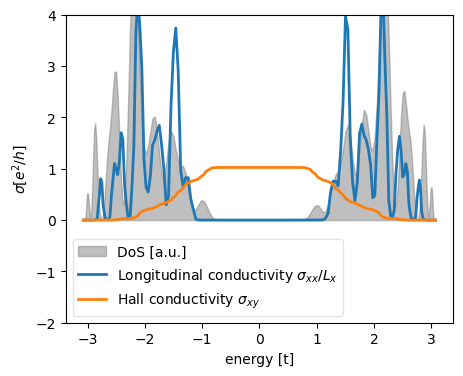

In [5]:
spectrum = kwant.kpm.SpectralDensity(fsyst, params=params)

plot_dos_and_curves(
    (spectrum.energies, spectrum.densities.real / (lx * ly / 3)),
    [
        (r'Longitudinal conductivity $\sigma_{xx}/L_x$',
         (spectrum.energies, cond_array_xx.mean(1) / (lx))),
        (r'Hall conductivity $\sigma_{xy}$',
         (spectrum.energies, cond_array_xy.mean(1)))],
    ylabel=r'$\sigma [e^2/h]$'
);


## Use open boundary velocity operators
(in a periodic system..! don't expect correct results)

In [6]:
s_factory = kwant.kpm.LocalVectors(fsyst, where=None)
vectors = list(s_factory)
num_vectors = len(vectors)

# number of sites per vector
norm_v = np.linalg.norm(vectors[0]) ** 2

cond_xx = kwant.kpm.conductivity(
    fsyst, params=params,
    bounds=bounds,
    alpha='x',
    beta='x',
    mean=False,
    num_vectors=num_vectors,
    vector_factory=vectors)

cond_xy = kwant.kpm.conductivity(
    fsyst, params=params,
    alpha='x',
    beta='y',
    mean=False,    
    num_vectors=num_vectors,
    vector_factory=vectors
)

energies = cond_xx.energies
cond_array_xx = np.array([cond_xx(e, temperature=0.0) for e in energies]).real
cond_array_xy = np.array([cond_xy(e, temperature=0.0) for e in energies]).real

# area of the unit cell per site
area_per_site = np.abs(np.cross(*lat.prim_vecs)) / len(lat.sublattices)
cond_array_xx /= area_per_site
cond_array_xy /= area_per_site

cond_array_xx = cond_array_xx / norm_v
cond_array_xy = cond_array_xy / norm_v

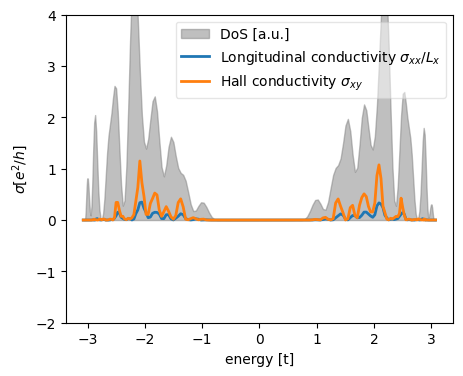

In [7]:
spectrum = kwant.kpm.SpectralDensity(fsyst, params=params)

plot_dos_and_curves(
    (spectrum.energies, spectrum.densities.real / (lx * ly / 3)),
    [
        (r'Longitudinal conductivity $\sigma_{xx} / L_x$',
         (spectrum.energies, cond_array_xx.mean(1) / (lx))),
        (r'Hall conductivity $\sigma_{xy}$',
         (spectrum.energies, cond_array_xy.mean(1)))],
    ylabel=r'$\sigma [e^2/h]$'
);